 Import packages and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from surprise import Reader, Dataset, SVD, SVDpp, NMF, KNNBaseline, evaluate, accuracy
from surprise.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression


r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')

m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url','unknown', 'Action', 'Adventure',\
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir', 'Horror',\
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, encoding='latin-1')

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1', parse_dates=True)

In [2]:
ratings['unix_timestamp'] = ratings['unix_timestamp'].apply(datetime.fromtimestamp)
ratings.columns = ['user_id', 'movie_id', 'rating', 'time']
ratings.head(10)

,user_id,movie_id,rating,time
0,196,242,3,1997-12-04 10:55:49
1,186,302,3,1998-04-04 14:22:22
2,22,377,1,1997-11-07 02:18:36
3,244,51,2,1997-11-27 00:02:03
4,166,346,1,1998-02-02 00:33:16
5,298,474,4,1998-01-07 09:20:06
6,115,265,2,1997-12-03 12:51:28
7,253,465,5,1998-04-03 13:34:27
8,305,451,3,1998-02-01 04:20:17
9,6,86,3,1997-12-31 16:16:53


Here we can see how ratings distributed.

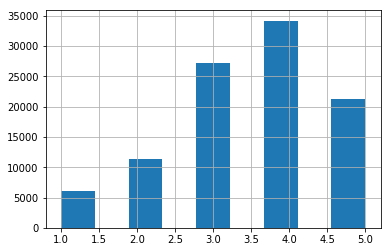

In [3]:
ratings['rating'].hist(bins=9)

So far we will only use the movie title from this DataFrame. We may need the types of the movie later in our model.

In [4]:
movies['release_date'] = pd.to_datetime(movies['release_date'])
movies.head(10)

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,1995-01-01,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,8,Babe (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,9,Dead Man Walking (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,Richard III (1995),1996-01-22,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [5]:
for i in users['occupation'].unique():
    users[i] = users['occupation'] == i
users.drop('occupation', axis=1, inplace=True)
users.head(10)

,user_id,age,sex,zip_code,technician,other,writer,executive,administrator,student,...,librarian,homemaker,artist,engineer,marketing,none,healthcare,retired,salesman,doctor
0,1,24,M,85711,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,53,F,94043,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,23,M,32067,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,24,M,43537,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,33,F,15213,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,6,42,M,98101,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
6,7,57,M,91344,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,8,36,M,05201,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
8,9,29,M,01002,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
9,10,53,M,90703,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


For each movie we count how many ratings it got, and what's the mean and standard deviation.

In [6]:
ratings_movie_summary = ratings.groupby('movie_id')['rating'].agg(['count', 'mean', 'std'])
ratings_movie_summary.head(10)

,count,mean,std
movie_id,,,
1,452,3.878319,0.927897
2,131,3.206107,0.966497
3,90,3.033333,1.212760
4,209,3.550239,0.965069
5,86,3.302326,0.946446
6,26,3.576923,1.301478
7,392,3.798469,0.982037
8,219,3.995434,1.002281
9,299,3.896321,1.042368


For each user, we count how many ratings he or she gives, and the mean and standard deviation as well.

In [7]:
ratings_user_summary = ratings.groupby('user_id')['rating'].agg(['count', 'mean', 'std'])
ratings_user_summary.head(10)

,count,mean,std
user_id,,,
1,272,3.610294,1.263585
2,62,3.709677,1.030472
3,54,2.796296,1.219026
4,24,4.333333,0.916831
5,175,2.874286,1.362963
6,211,3.635071,1.039461
7,403,3.965261,1.064480
8,59,3.796610,1.242629
9,22,4.272727,0.935125


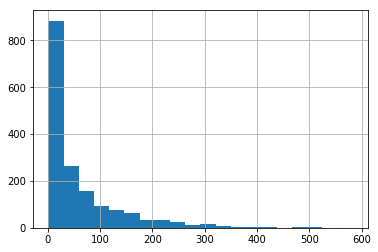

In [8]:
ratings_movie_summary.sort_values(by='count')['count'].hist(bins=20)

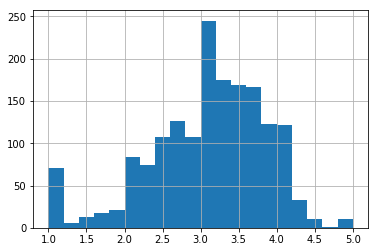

In [9]:
ratings_movie_summary.sort_values(by='mean')['mean'].hist(bins=20)

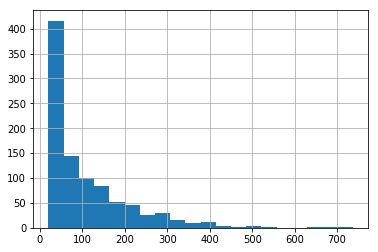

In [10]:
ratings_user_summary.sort_values(by='count')['count'].hist(bins=20)

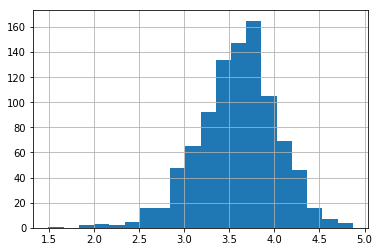

In [11]:
ratings_user_summary.sort_values(by='mean')['mean'].hist(bins=20)

We create a pivot table for ratings and store the total mean and standard deviation values.

In [12]:
ratings_p = pd.pivot_table(ratings, values='rating', index='user_id', columns='movie_id')
ratings_p.iloc[:10, :10]

movie_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN
7,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0
8,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN


In [13]:
mean = ratings_p.stack().mean()
std = ratings_p.stack().std()

- **SVD Model**

Here is the Singular Value Decomposition method using the surprise package.

In [14]:
#trainset, testset = train_test_split(ratings, test_size=0.15, random_state=0)

reader = Reader()
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)
#data.split(n_folds=3)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/anaconda3/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/anaconda3/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9378
MAE:  0.7401
------------
Fold 2
RMSE: 0.9391
MAE:  0.7384
------------
Fold 3
RMSE: 0.9366
MAE:  0.7372
------------
Fold 4
RMSE: 0.9326
MAE:  0.7353
------------
Fold 5
RMSE: 0.9406
MAE:  0.7436
------------
------------
Mean RMSE: 0.9373
Mean MAE : 0.7389
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.9377976153549861,
                             0.939104859431426,
                             0.9365997863324468,
                             0.9325888203609853,
                             0.9406187273204947],
                            'mae': [0.7400922084212521,
                             0.7384082569119351,
                             0.7371635885466925,
                             0.7353120266770539,
                             0.7436426002139366]})

---
numpy.linalg.svd experiment

In [15]:
trainset = data.build_full_trainset()
testset = trainset.build_testset()
predictions = svd.test(testset)
model_pred = pd.DataFrame([[i.uid, i.iid, i.est] for i in predictions], columns=['user_id', 'movie_id', 'svd'])
model_pred.shape

(100000, 3)

In [16]:
anti_testset = trainset.build_anti_testset()
anti_predictions = svd.test(anti_testset)
model_pred_anti = pd.DataFrame([[i.uid, i.iid, i.est] for i in anti_predictions], columns=['user_id', 'movie_id', 'svd'])
model_pred = pd.concat([model_pred, model_pred_anti], ignore_index=True)
model_pred.shape

(1586126, 3)

In [17]:
svd_p = pd.pivot_table(model_pred, values='svd', index='user_id', columns='movie_id')
svd_p.iloc[:10, :10]

movie_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,4.046208,3.134853,3.806769,3.655800,2.969818,4.107507,4.145638,3.824170,4.432500,3.638340
2,4.117208,3.385481,3.278004,3.537121,3.333670,4.085825,3.511899,3.956142,3.924821,4.105132
3,3.437468,2.629064,2.471522,3.122192,2.938676,3.380326,3.758950,4.151197,3.719288,3.398250
4,4.678449,4.091196,4.054334,4.148908,4.095731,4.801707,4.269675,4.417162,4.593331,4.829538
5,3.217502,2.554633,2.804608,3.006256,2.640993,3.114872,3.333294,3.441495,3.518919,3.341342
6,3.646967,2.634448,2.926123,3.180021,3.038208,3.481281,2.924350,3.800642,3.881775,4.076492
7,4.034423,3.619312,3.317878,3.839601,3.935731,3.779605,4.081024,4.231017,4.419463,4.305721
8,4.331660,3.529902,3.435795,3.755186,3.428542,4.048429,3.662222,4.111709,4.147701,4.058041
9,4.595878,3.521081,3.520901,3.831720,3.728502,4.410904,4.005939,4.193736,4.018170,4.364065


In [18]:
svd_p = np.array(svd_p)
u, s, vt = np.linalg.svd(svd_p, full_matrices=False)
sigma = np.diag(s)
print(u.shape, sigma.shape, vt.shape)
pd.DataFrame(sigma[:10, :10])

(943, 943) (943, 943) (943, 1682)


,0,1,2,3,4,5,6,7,8,9
0,4321.366617,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,73.04643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.00000,57.074389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.00000,0.000000,40.793046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.00000,0.000000,0.000000,35.462222,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.00000,0.000000,0.000000,0.000000,34.620016,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,34.149464,0.000000,0.000000,0.000000
7,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,32.264965,0.000000,0.000000
8,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.060269,0.000000
9,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.758319


In [19]:
pd.DataFrame(np.matmul(u, np.matmul(sigma, vt))).iloc[:10, :10]

,0,1,2,3,4,5,6,7,8,9
0,4.046208,3.134853,3.806769,3.655800,2.969818,4.107507,4.145638,3.824170,4.432500,3.638340
1,4.117208,3.385481,3.278004,3.537121,3.333670,4.085825,3.511899,3.956142,3.924821,4.105132
2,3.437468,2.629064,2.471522,3.122192,2.938676,3.380326,3.758950,4.151197,3.719288,3.398250
3,4.678449,4.091196,4.054334,4.148908,4.095731,4.801707,4.269675,4.417162,4.593331,4.829538
4,3.217502,2.554633,2.804608,3.006256,2.640993,3.114872,3.333294,3.441495,3.518919,3.341342
5,3.646967,2.634448,2.926123,3.180021,3.038208,3.481281,2.924350,3.800642,3.881775,4.076492
6,4.034423,3.619312,3.317878,3.839601,3.935731,3.779605,4.081024,4.231017,4.419463,4.305721
7,4.331660,3.529902,3.435795,3.755186,3.428542,4.048429,3.662222,4.111709,4.147701,4.058041
8,4.595878,3.521081,3.520901,3.831720,3.728502,4.410904,4.005939,4.193736,4.018170,4.364065
9,4.113933,3.434080,3.540219,3.761381,3.576478,4.149051,3.935102,4.191976,4.142839,4.391246


---

Cross-Validation for SVD.

In [20]:
#from surprise.model_selection import GridSearchCV
#from surprise.model_selection import cross_validate

#param_grid = {'n_factors': [110, 120, 140, 160], 'n_epochs': [90, 100, 110], 'lr_all': [0.001, 0.003, 0.005, 0.008],
#              'reg_all': [0.08, 0.1, 0.15]}
#gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
#gs.fit(data)
#algo = gs.best_estimator['rmse']
#print(gs.best_score['rmse'])
#print(gs.best_params['rmse'])
#cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [22]:
# param_grid = {'n_factors': [70, 80, 90, 100, 110, 120, 130, 140, 150, 160], 'n_epochs': [100], 'reg_all': [0.1]}
# gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
# gs_svd.fit(data)
# svd = gs_svd.best_estimator['rmse']
# print(gs_svd.best_score['rmse'])
# print(gs_svd.best_params['rmse'])

In [25]:
# cv_results_svd = pd.DataFrame(gs_svd.cv_results)
# fig = plt.figure(figsize=(15, 6))
# plt.subplot(121)
# plt.plot(cv_results_svd['mean_test_rmse'])
# plt.xticks(np.arange(10), np.arange(70, 170, 10), fontsize=13)
# plt.yticks(fontsize=13)
# plt.xlabel('number of latent factors', fontsize=16)
# plt.ylabel('Root Mean Square Error (RMSE)', fontsize=16)
# plt.grid()
# plt.legend()
# plt.subplot(122)
# plt.plot(cv_results_svd['mean_test_mae'])
# plt.xticks(np.arange(10), np.arange(70, 170, 10), fontsize=13)
# plt.yticks(fontsize=13)
# plt.xlabel('number of latent factors', fontsize=16)
# plt.ylabel('Mean Absolute Error (MAE)', fontsize=16)
# plt.grid()
# plt.legend()
# plt.show()

Use the CV best model to recommend movies for user 196.

In [24]:
eval_svd = evaluate(svd, data, measures=['RMSE', 'MAE'])
trainset = data.build_full_trainset()
svd.fit(trainset)

/anaconda3/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/anaconda3/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9395
MAE:  0.7418
------------
Fold 2
RMSE: 0.9384
MAE:  0.7369
------------
Fold 3
RMSE: 0.9363
MAE:  0.7386
------------
Fold 4
RMSE: 0.9336
MAE:  0.7365
------------
Fold 5
RMSE: 0.9368
MAE:  0.7419
------------
------------
Mean RMSE: 0.9369
Mean MAE : 0.7392
------------
------------


In [26]:
df_196 = ratings[ratings['user_id'] == 196]
df_196 = df_196.set_index('movie_id')
df_196 = df_196.join(movies)['title']
print(df_196.sort_index())

movie_id
8                                 Dead Man Walking (1995)
13                                     Postino, Il (1994)
25                          Brothers McMullen, The (1995)
66                      Ace Ventura: Pet Detective (1994)
67                                       Crow, The (1994)
70                                  Lion King, The (1994)
94                                         Aladdin (1992)
108        Mystery Science Theater 3000: The Movie (1996)
110                   Truth About Cats & Dogs, The (1996)
111                                        Flipper (1996)
116                                      Rock, The (1996)
153                   Monty Python's Life of Brian (1979)
173                        Raiders of the Lost Ark (1981)
202                                     Unforgiven (1992)
238                                       Sneakers (1992)
242                                  Jungle2Jungle (1997)
251                 Lost World: Jurassic Park, The (1997)
257  

In [27]:
user_196_svd = movies[['movie_id', 'title', 'release_date']]
user_196_svd['Estimate_Score'] = user_196_svd['movie_id'].apply(lambda x: svd.predict('196', x).est)
user_196_svd = user_196_svd.drop('movie_id', axis = 1)
user_196_svd = user_196_svd.sort_values('Estimate_Score', ascending=False)
print(user_196_svd.head(10))

                                                 title release_date  \
407                              Close Shave, A (1995)   1996-04-28   
317                            Schindler's List (1993)   1993-01-01   
168                         Wrong Trousers, The (1993)   1993-01-01   
63                    Shawshank Redemption, The (1994)   1994-01-01   
482                                  Casablanca (1942)   1942-01-01   
113  Wallace & Gromit: The Best of Aardman Animatio...   1996-04-05   
602                                 Rear Window (1954)   1954-01-01   
177                                12 Angry Men (1957)   1957-01-01   
11                          Usual Suspects, The (1995)   1995-08-14   
512                              Third Man, The (1949)   1949-01-01   

     Estimate_Score  
407        4.577329  
317        4.566657  
168        4.550977  
63         4.547143  
482        4.538884  
113        4.500653  
602        4.450221  
177        4.446165  
11         4.426820 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


- **SVD++ Model**

Improved SVD model with implicit terms.

In [28]:
svdpp = SVDpp()
evaluate(svdpp, data, measures=['RMSE', 'MAE'])

/anaconda3/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/anaconda3/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVDpp.

------------
Fold 1


KeyboardInterrupt: 

Grid Search on SVDpp model

In [ ]:
# param_grid = {'lr_all': [0.001, 0.003, 0.005, 0.007, 0.009], 'reg_all': [0.005, 0.01, 0.015, 0.02, 0.025]}
# gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
# gs_svdpp.fit(data)
# svdpp = gs_svdpp.best_estimator['rmse']
# print(gs_svdpp.best_score['rmse'])
# print(gs_svdpp.best_params['rmse'])

In [ ]:
# cv_results_svdpp = pd.DataFrame(gs_svdpp.cv_results)
# svdpp_rmse = np.array(cv_results_svdpp['mean_test_rmse']).reshape(5,5)
# svdpp_mae = np.array(cv_results_svdpp['mean_test_mae']).reshape(5,5)
# fig = plt.figure(figsize=(15,6))
# ax1 = plt.subplot(121)
# im1 = ax1.imshow(svdpp_rmse)
# cbar = ax1.figure.colorbar(im1, ax=ax1)
# ax1.set_xticks(np.arange(5))
# ax1.set_yticks(np.arange(5))
# ax1.set_xticklabels(param_grid['lr_all'], fontsize=13)
# ax1.set_yticklabels(param_grid['reg_all'], fontsize=13)
# for i in range(5):
#     for j in range(5):
#         text = ax1.text(j, i, round(svdpp_rmse[i][j], 4), ha="center", va="center", color="w")
# ax1.set_xlabel('reg_all', fontsize=16)
# ax1.set_ylabel('lr_all', fontsize=16)
# ax1.set_title('Root Mean Square Error (RMSE)', fontsize=16)
# ax2 = plt.subplot(122)
# im2 = ax2.imshow(svdpp_mae)
# cbar = ax2.figure.colorbar(im2, ax=ax2)
# ax2.set_xticks(np.arange(5))
# ax2.set_yticks(np.arange(5))
# ax2.set_xticklabels(param_grid['lr_all'], fontsize=13)
# ax2.set_yticklabels(param_grid['reg_all'], fontsize=13)
# for i in range(5):
#     for j in range(5):
#         text = ax2.text(j, i, round(svdpp_mae[i][j], 4), ha="center", va="center", color="w")
# ax2.set_xlabel('reg_all', fontsize=16)
# ax2.set_ylabel('lr_all', fontsize=16)
# ax2.set_title('Mean Absolute Error (MAE)', fontsize=16)
# plt.show()

And here is the CV best model's proformance.

In [ ]:
eval_svdpp = evaluate(svdpp, data, measures=['RMSE', 'MAE'])

- **NMF Model**

Non-Negative Matrix Factoraization.

In [ ]:
nmf = NMF()
evaluate(nmf, data, measures=['RMSE', 'MAE'])

NMF model with biased term. (Similar to SVD)

Reduce n_factors to avoid over-fitting.

In [ ]:
# param_grid = {'n_factors': [1,2,3,4,5,6,7,8,9,10], 'n_epochs': [100], 'biased': [True], 'reg_bu': [0.1], 'reg_bi': [0.1]}
# gs_nmfb = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=3)
# gs_nmfb.fit(data)
# nmfb = gs_nmfb.best_estimator['rmse']
# print(gs_nmfb.best_score['rmse'])
# print(gs_nmfb.best_params['rmse'])

In [ ]:
# cv_results_nmfb = pd.DataFrame(gs_nmfb.cv_results)
# fig = plt.figure(figsize=(15, 6))
# plt.subplot(121)
# plt.plot(cv_results_nmfb['mean_test_rmse'])
# plt.xticks(np.arange(10), np.arange(1, 11), fontsize=13)
# plt.yticks(fontsize=13)
# plt.xlabel('number of latent factors', fontsize=16)
# plt.ylabel('Root Mean Square Error (RMSE)', fontsize=16)
# plt.grid()
# plt.legend()
# plt.subplot(122)
# plt.plot(cv_results_nmfb['mean_test_mae'])
# plt.xticks(np.arange(10), np.arange(1, 11), fontsize=13)
# plt.yticks(fontsize=13)
# plt.xlabel('number of latent factors', fontsize=16)
# plt.ylabel('Mean Absolute Error (MAE)', fontsize=16)
# plt.grid()
# plt.legend()
# plt.show()

In [ ]:
eval_nmfb = evaluate(nmfb, data, measures=['RMSE', 'MAE'])

NMF model after grid search.

In [ ]:
param_grid = {'n_factors': [200, 220, 240], 'n_epochs': [90, 100, 110]}
gs_nmf = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=3)
gs_nmf.fit(data)
nmf = gs_nmf.best_estimator['rmse']
print(gs_nmf.best_score['rmse'])
print(gs_nmf.best_params['rmse'])

In [ ]:
eval_nmf = evaluate(nmf, data, measures=['RMSE', 'MAE'])

- **kNN Model**

K-Nearest Neighbour model with ALS baseline prediction.

Alternating Least Square (ALS)

In [ ]:
knnb = KNNBaseline(k=50)
evaluate(knnb, data, measures=['RMSE', 'MAE'])

Item_based kNN model

In [ ]:
knnb_1 = KNNBaseline(k=60, sim_options = {'user_based': False})
eval_knnb_1 = evaluate(knnb_1, data, measures=['RMSE', 'MAE'])

kNN with SGD baseline.

Stochastic Gradient Descent (SGD)

---

Grid Search on kNN

In [ ]:
param_grid = {'k': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'sim_options': {'user_based': [True, False]},\
              'bsl_options': {'method': ['als', 'sgd']}}
gs_knn = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs_knn.fit(data)
print(gs_knn.best_score['rmse'])
print(gs_knn.best_params['rmse'])

In [ ]:
cv_results_knn = pd.DataFrame(gs_knn.cv_results)
index = np.arange(0, 40, 4)
fig = plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(cv_results_knn.loc[index, 'mean_test_rmse'].tolist(), label='user_based_als')
plt.plot(cv_results_knn.loc[index+1, 'mean_test_rmse'].tolist(), label='user_based_sgd')
plt.plot(cv_results_knn.loc[index+2, 'mean_test_rmse'].tolist(), label='item_based_als')
plt.plot(cv_results_knn.loc[index+3, 'mean_test_rmse'].tolist(), label='item_based_sgd')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index, 'mean_test_rmse'].tolist(), cv_results_knn.loc[index, 'std_test_rmse'].tolist(), capsize=8, label='user_based_als')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index+1, 'mean_test_rmse'].tolist(), cv_results_knn.loc[index+1, 'std_test_rmse'].tolist(), capsize=8, label='user_based_sgd')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index+2, 'mean_test_rmse'].tolist(), cv_results_knn.loc[index+2, 'std_test_rmse'].tolist(), capsize=8, label='item_based_als')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index+3, 'mean_test_rmse'].tolist(), cv_results_knn.loc[index+3, 'std_test_rmse'].tolist(), capsize=8, label='item_based_sgd')
plt.xticks(np.arange(10), np.arange(10, 110, 10), fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('number of neighbors (k)', fontsize=16)
plt.ylabel('Root Mean Square Error (RMSE)', fontsize=16)
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(cv_results_knn.loc[index, 'mean_test_mae'].tolist(), label='user_based_als')
plt.plot(cv_results_knn.loc[index+1, 'mean_test_mae'].tolist(), label='user_based_sgd')
plt.plot(cv_results_knn.loc[index+2, 'mean_test_mae'].tolist(), label='item_based_als')
plt.plot(cv_results_knn.loc[index+3, 'mean_test_mae'].tolist(), label='item_based_sgd')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index, 'mean_test_mae'].tolist(), cv_results_knn.loc[index, 'std_test_mae'].tolist(), capsize=8, label='user_based_als')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index+1, 'mean_test_mae'].tolist(), cv_results_knn.loc[index+1, 'std_test_mae'].tolist(), capsize=8, label='user_based_sgd')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index+2, 'mean_test_mae'].tolist(), cv_results_knn.loc[index+2, 'std_test_mae'].tolist(), capsize=8, label='item_based_als')
#plt.errorbar(np.arange(10), cv_results_knn.loc[index+3, 'mean_test_mae'].tolist(), cv_results_knn.loc[index+3, 'std_test_mae'].tolist(), capsize=8, label='item_based_sgd')
plt.xticks(np.arange(10), np.arange(10, 110, 10), fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('number of neighbors (k)', fontsize=16)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=16)
plt.grid()
plt.legend()
plt.show()

In [ ]:
knnb = KNNBaseline(k=70, sim_options = {'user_based': False}, bsl_options = {'method': 'sgd', 'n_epochs': 100})
eval_knnb = evaluate(knnb, data, measures=['RMSE', 'MAE'])

In [ ]:
### All models after grid search.
svd = SVD(n_factors=140, n_epochs=100, reg_all=0.1)
eval_svd = evaluate(svd, data, measures=['RMSE', 'MAE'])
svdpp = SVDpp(lr_all=0.005, reg_all=0.015)
eval_svdpp = evaluate(svdpp, data, measures=['RMSE', 'MAE'])
nmfb = NMF(n_factors=3, n_epochs=100, biased=True, reg_bu=0.1, reg_bi=0.1)
eval_nmfb = evaluate(nmfb, data, measures=['RMSE', 'MAE'])
nmf = NMF(n_factors=240, n_epochs=90)
eval_nmf = evaluate(nmf, data, measures=['RMSE', 'MAE'])
knnb_1 = KNNBaseline(k=60, sim_options = {'user_based': False})
eval_knnb_1 = evaluate(knnb_1, data, measures=['RMSE', 'MAE'])
knnb = KNNBaseline(k=70, sim_options = {'user_based': False}, bsl_options = {'method': 'sgd', 'n_epochs': 100})
eval_knnb = evaluate(knnb, data, measures=['RMSE', 'MAE'])

Import our Baseline_SVM model from the Baseline notebook

In [ ]:
from sklearn.svm import SVR

movie_mean = np.ones(ratings_p.shape)
movie_mean = pd.DataFrame(movie_mean * np.array(ratings_movie_summary['mean']).reshape(1,1682))
X = np.array(ratings_p*0) + movie_mean
svm = SVR(gamma=1, C=1)
pred_svm = ratings_p.copy()
for i in range(ratings_p.shape[0]):
    svm.fit(np.array(X.iloc[i].dropna()).reshape(-1,1), ratings_p.iloc[i].dropna())
    pred_svm.iloc[i] = svm.predict(np.array(movie_mean.iloc[0]).reshape(-1,1))
score_svm = abs(np.array(ratings_p) - pred_svm)
score_2_svm = score_svm ** 2
print('RMSE: {:.4f}'.format(np.sqrt(score_2_svm.stack().mean())))
print('MAE: {:.4f}'.format(score_svm.stack().mean()))

- **Ultimate Model**

**We can improve all these by combine all models together.**

First let's collect the prediction results in a data frame.

In [ ]:
trainset = data.build_full_trainset()
testset = trainset.build_testset()
pred = ratings[['user_id', 'movie_id', 'rating']]
l = [svd, svdpp, nmf, nmfb, knnb, knnb_1]
for i in range(len(l)):
    predictions = l[i].test(testset)
    model_pred = pd.DataFrame([[i.uid, i.iid, i.est] for i in predictions], columns=['user_id', 'movie_id', str(i)])
    pred = pd.merge(pred, model_pred, how='left', left_on=['user_id', 'movie_id'], right_on=['user_id', 'movie_id'])
pred.columns = pred.columns[:3].tolist() + ['svd', 'svdpp', 'nmf', 'nmfb', 'knnb', 'knnb_1']
#pred = pd.merge(pred, users, on='user_id')
#pred = pd.merge(pred, movies, on='movie_id')
#pred['sex'] = pred['sex'].replace(['F', 'M'], [1, 0])
#pred.drop(['release_date', 'video_release_date', 'imdb_url', 'title', 'zip_code'], axis=1, inplace=True)

In [ ]:
pred['svm'] = np.zeros(pred.shape[0])
for i in pred.index:
    pred.loc[i, 'svm'] = pred_svm.loc[pred.loc[i, 'user_id'], pred.loc[i, 'movie_id']]
pred.head()

Then we apply all this into a linear regression to see the weight we should put on each model.

Here we can also see the RMSE and MAE score before train test split.

In [ ]:
linreg = LinearRegression().fit(pred.iloc[:, 3:], pred['rating'])

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
pred['pred'] = linreg.predict(pred.iloc[:, 3:])
print('RMSE: {:.4f}'.format(np.sqrt(((pred['pred'] - pred['rating']) ** 2).mean())))
print('MAE: {:.4f}'.format(abs(pred['pred'] - pred['rating']).mean()))

Cross Validation

We start by collect prediction values for 5 folds.

In [ ]:
kf = KFold(n_splits=5, random_state=13)
l = [svd, svdpp, nmf, nmfb, knnb, knnb_1]
predCV = ratings[['user_id', 'movie_id', 'rating']]
predCV_train = ratings[['user_id', 'movie_id', 'rating']]
for trainset, testset in kf.split(data):
    for i in range(len(l)):
        l[i].fit(trainset)
        predictions = l[i].test(testset)
        model_pred = pd.DataFrame([[i.uid, i.iid, i.est] for i in predictions], columns=['user_id', 'movie_id', str(i)])
        predCV = pd.merge(predCV, model_pred, how='outer', left_on=['user_id', 'movie_id'], right_on=['user_id', 'movie_id'])
        testset_train = trainset.build_testset()
        predictions = l[i].test(testset_train)
        model_pred_train = pd.DataFrame([[i.uid, i.iid, i.est] for i in predictions], columns=['user_id', 'movie_id', str(i)])
        predCV_train = pd.merge(predCV_train, model_pred_train, how='outer', left_on=['user_id', 'movie_id'], right_on=['user_id', 'movie_id'])
predCV.columns = ['user_id', 'movie_id', 'rating', 'svd_1', 'svdpp_1', 'nmf_1', 'nmfb_1', 'knnb_1', 'knnb_1_1',\
                  'svd_2', 'svdpp_2', 'nmf_2', 'nmfb_2', 'knnb_2', 'knnb_1_2',\
                  'svd_3', 'svdpp_3', 'nmf_3', 'nmfb_3', 'knnb_3', 'knnb_1_3',\
                  'svd_4', 'svdpp_4', 'nmf_4', 'nmfb_4', 'knnb_4', 'knnb_1_4',\
                  'svd_5', 'svdpp_5', 'nmf_5', 'nmfb_5', 'knnb_5', 'knnb_1_5']
predCV_train.columns = ['user_id', 'movie_id', 'rating', 'svd_1', 'svdpp_1', 'nmf_1', 'nmfb_1', 'knnb_1', 'knnb_1_1',\
                        'svd_2', 'svdpp_2', 'nmf_2', 'nmfb_2', 'knnb_2', 'knnb_1_2',\
                        'svd_3', 'svdpp_3', 'nmf_3', 'nmfb_3', 'knnb_3', 'knnb_1_3',\
                        'svd_4', 'svdpp_4', 'nmf_4', 'nmfb_4', 'knnb_4', 'knnb_1_4',\
                        'svd_5', 'svdpp_5', 'nmf_5', 'nmfb_5', 'knnb_5', 'knnb_1_5']
predCV_train.head()

Add the results from Baseline_SVM into the DataFrame

In [ ]:
index = pd.DataFrame(predCV['svd_1'])
index['svd_2'] = predCV['svd_2']
index['svd_3'] = predCV['svd_3']
index['svd_4'] = predCV['svd_4']
index['svd_5'] = predCV['svd_5']
index = index*0+1
index.columns = [1,2,3,4,5]

rmse_svm = []
mae_svm = []
fold = 0
movie_mean = pd.DataFrame(np.ones(ratings_p.shape) * np.array(ratings_movie_summary['mean']).reshape(1,1682))
print('Evaluating RMSE, MAE of the Baseline_SVM Model. \n')
print('-'*12)
for i in index.columns:
    train = ratings.copy()
    test = ratings.copy()
    train['rating'] = train['rating']*(index[i].isna())
    train['rating'].replace(0, np.NaN, inplace=True)
    test['rating'] = test['rating']*index[i]
    train_movie_summary = train.groupby('movie_id')['rating'].agg(['count', 'mean', 'std'])
    train_user_summary = train.groupby('user_id')['rating'].agg(['count', 'mean', 'std'])
    train_p = pd.pivot_table(train, values='rating', index='user_id', columns='movie_id', dropna=False)
    test_p = pd.pivot_table(test, values='rating', index='user_id', columns='movie_id', dropna=False)
    train_mean = pd.DataFrame(np.ones(ratings_p.shape) * np.array(train_movie_summary['mean']).reshape(1,1682))
    X = np.array(train_p*0) + train_mean
    pred = ratings_p.copy()
    for j in range(ratings_p.shape[0]):
        svm.fit(np.array(X.iloc[j].dropna()).reshape(-1,1), train_p.iloc[j].dropna())
        pred.iloc[j] = svm.predict(np.array(movie_mean.iloc[0]).reshape(-1,1))
    predCV['svm_'+str(i)] = np.zeros(predCV.shape[0])
    for x in predCV.index:
        predCV.loc[x, 'svm_'+str(i)] = pred.loc[predCV.loc[x, 'user_id'], predCV.loc[x, 'movie_id']]
    predCV['svm_'+str(i)] = index[i] * predCV['svm_'+str(i)]
    predCV_train['svm_'+str(i)] = np.zeros(predCV.shape[0])
    for x in predCV_train.index:
        predCV_train.loc[x, 'svm_'+str(i)] = pred.loc[predCV_train.loc[x, 'user_id'], predCV_train.loc[x, 'movie_id']]
    predCV_train['svm_'+str(i)] = (index[i].isna()) * predCV_train['svm_'+str(i)]
    predCV_train.replace(0, np.NaN, inplace=True)
    score = abs(np.array(test_p) - pred)
    score_2 = score ** 2
    rmse_svm += [np.sqrt(score_2.stack().mean())]
    mae_svm += [score.stack().mean()]
    fold += 1
    print('Fold', fold)
    print('RMSE: {:.4f}'.format(np.sqrt(score_2.stack().mean())))
    print('MAE: {:.4f}'.format(score.stack().mean()))
    print('-'*12)
print('-'*12)
print('Mean RMSE: {:.4f}'.format(np.mean(rmse_svm)))
print('Mean MAE: {:.4f}'.format(np.mean(mae_svm)))
print('-'*12)
print('-'*12)

In [ ]:
columns=['user_id', 'movie_id', 'rating', 'svd_1', 'svdpp_1', 'nmf_1', 'nmfb_1', 'knnb_1', 'knnb_1_1', 'svm_1',\
         'svd_2', 'svdpp_2', 'nmf_2', 'nmfb_2', 'knnb_2', 'knnb_1_2', 'svm_2',\
         'svd_3', 'svdpp_3', 'nmf_3', 'nmfb_3', 'knnb_3', 'knnb_1_3', 'svm_3',\
         'svd_4', 'svdpp_4', 'nmf_4', 'nmfb_4', 'knnb_4', 'knnb_1_4', 'svm_4',\
         'svd_5', 'svdpp_5', 'nmf_5', 'nmfb_5', 'knnb_5', 'knnb_1_5', 'svm_5']
predCV=predCV.reindex(columns=columns)
predCV_train=predCV_train.reindex(columns=columns)
coef = linreg.coef_
for i in range(1, 6):
    predCV['fold_'+str(i)] = coef[0] * predCV['svd_'+str(i)] + coef[1] * predCV['svdpp_'+str(i)] +\
                             coef[2] * predCV['nmf_'+str(i)] + coef[3] * predCV['nmfb_'+str(i)] +\
                             coef[4] * predCV['knnb_'+str(i)] + coef[5] * predCV['knnb_1_'+str(i)] +\
                             coef[6] * predCV['svm_'+str(i)] + linreg.intercept_
predCV.head()

Cross-Validation result

In [ ]:
rmse_ult = []
mae_ult = []
print('Evaluating RMSE, MAE of the Ultimate Model. \n')
print('-'*12)
for fold in range(1, 6):
    print('Fold', fold)
    rmse_ult += [np.sqrt(((predCV['fold_'+str(fold)] - predCV['rating']) ** 2).mean())]
    mae_ult += [abs(predCV['fold_'+str(fold)] - predCV['rating']).mean()]
    print('RMSE: {:.4f}'.format(np.sqrt(((predCV['fold_'+str(fold)] - predCV['rating']) ** 2).mean())))
    print('MAE: {:.4f}'.format(abs(predCV['fold_'+str(fold)] - predCV['rating']).mean()))
    print('-'*12)
print('-'*12)
print('Mean RMSE: {:.4f}'.format(np.mean(rmse_ult)))
print('Mean MAE: {:.4f}'.format(np.mean(mae_ult)))
print('-'*12)
print('-'*12)

Here is the case when we update the coefficient for each fold.

In [ ]:
predCV_1 = predCV.copy()
for i in range(5):
    s = predCV_train.iloc[:, 7*i+3:7*(i+1)+3]
    s['rating'] = predCV_train['rating']
    s.dropna(inplace=True)
    linreg = LinearRegression().fit(s.drop('rating', axis=1), s['rating'])
    coef = linreg.coef_
    predCV_1['fold_'+str(i+1)] = coef[0] * predCV['svd_'+str(i+1)] + coef[1] * predCV['svdpp_'+str(i+1)] +\
                                 coef[2] * predCV['nmf_'+str(i+1)] + coef[3] * predCV['nmfb_'+str(i+1)] +\
                                 coef[4] * predCV['knnb_'+str(i+1)] + coef[5] * predCV['knnb_1_'+str(i+1)] +\
                                 coef[6] * predCV['svm_'+str(i+1)] + linreg.intercept_

In [ ]:
rmse_ult = []
mae_ult = []
print('Evaluating RMSE, MAE of the Ultimate Model. \n')
print('-'*12)
for fold in range(1, 6):
    print('Fold', fold)
    rmse_ult += [np.sqrt(((predCV_1['fold_'+str(fold)] - predCV_1['rating']) ** 2).mean())]
    mae_ult += [abs(predCV_1['fold_'+str(fold)] - predCV_1['rating']).mean()]
    print('RMSE: {:.4f}'.format(np.sqrt(((predCV_1['fold_'+str(fold)] - predCV_1['rating']) ** 2).mean())))
    print('MAE: {:.4f}'.format(abs(predCV_1['fold_'+str(fold)] - predCV_1['rating']).mean()))
    print('-'*12)
print('-'*12)
print('Mean RMSE: {:.4f}'.format(np.mean(rmse_ult)))
print('Mean MAE: {:.4f}'.format(np.mean(mae_ult)))
print('-'*12)
print('-'*12)

In [ ]:
surprise_results = {'SVD': [np.mean(eval_svd['rmse']), np.mean(eval_svd['mae'])], 'SVDpp': [np.mean(eval_svdpp['rmse']), np.mean(eval_svdpp['mae'])],\
                    'NMF': [np.mean(eval_nmf['rmse']), np.mean(eval_nmf['mae'])], 'Biased_NMF': [np.mean(eval_nmfb['rmse']), np.mean(eval_nmfb['mae'])],\
                    'kNN_SGD': [np.mean(eval_knnb['rmse']), np.mean(eval_knnb['mae'])], 'kNN_ALS': [np.mean(eval_knnb_1['rmse']), np.mean(eval_knnb_1['mae'])],\
                    'Baseline_SVM': [np.mean(rmse_svm), np.mean(mae_svm)], 'Ultimate': [np.mean(rmse_ult), np.mean(mae_ult)]}
surprise_results = pd.DataFrame(surprise_results, index=['RMSE', 'MAE']).T
surprise_results

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
ax.set_axisbelow(True)
plt.bar(np.arange(1, 3*surprise_results.shape[0], 3), surprise_results['RMSE']-0.7, width=1, label='RMSE')
plt.bar(np.arange(2, 3*surprise_results.shape[0], 3), surprise_results['MAE']-0.7, width=1, label='MAE')
plt.xticks(np.arange(1.5, 3*surprise_results.shape[0], 3), surprise_results.index)
plt.yticks(np.arange(0, 0.4, 0.1), [0.7, 0.8, 0.9, 1.0])
plt.grid()
plt.legend()
plt.show()

In [ ]:
a = ratings.copy()
a['pred'] = np.zeros(ratings.shape[0])
for i in range(1, 6):
    a['pred'] = a['pred'] + predCV_1['fold_'+str(i)].replace(np.NaN, 0)
pred_1 = a[a['rating']==1]
pred_2 = a[a['rating']==2]
pred_3 = a[a['rating']==3]
pred_4 = a[a['rating']==4]
pred_5 = a[a['rating']==5]

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
hist_4 = plt.hist(pred_4['pred'], bins=100, alpha=0.5, label='4')
hist_3 = plt.hist(pred_3['pred'], bins=100, alpha=0.5, label='3')
hist_5 = plt.hist(pred_5['pred'], bins=100, alpha=0.5, label='5')
hist_2 = plt.hist(pred_2['pred'], bins=100, alpha=0.5, label='2')
hist_1 = plt.hist(pred_1['pred'], bins=100, alpha=0.5, label='1')
handles, labels = ax.get_legend_handles_labels()
handles = [handles.pop(2)]+handles
plt.legend(handles=handles[::-1], title='True Values')
plt.ylabel('Number of Ratings', fontsize=16)
plt.xlabel('Prediction Values', fontsize=16)
plt.title('Prediction Distribution by True Values', fontsize=16)
plt.xlim(0, 6)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [ ]:
fake_1 = pred[pred['rating']==1]
fake_2 = pred[pred['rating']==2]
fake_3 = pred[pred['rating']==3]
fake_4 = pred[pred['rating']==4]
fake_5 = pred[pred['rating']==5]

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
hist_4 = plt.hist(fake_4['pred'], bins=100, alpha=0.5, label='4')
hist_3 = plt.hist(fake_3['pred'], bins=100, alpha=0.5, label='3')
hist_5 = plt.hist(fake_5['pred'], bins=100, alpha=0.5, label='5')
hist_2 = plt.hist(fake_2['pred'], bins=100, alpha=0.5, label='2')
hist_1 = plt.hist(fake_1['pred'], bins=100, alpha=0.5, label='1')
handles, labels = ax.get_legend_handles_labels()
handles = [handles.pop(2)]+handles
plt.legend(handles=handles[::-1], title='True Values')
plt.ylabel('Number of Ratings', fontsize=16)
plt.xlabel('Prediction Values', fontsize=16)
plt.title('Prediction Distribution by True Values (Without Train Test Split)', fontsize=16)
plt.xlim(0, 6)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()